# Classification of Dogs and Cats using Convolutional Neural Networks


In [1]:
 import os
#Find out platform where we are running.
PLATFORM = "GENERIC"
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  PLATFORM = "COLAB"
else:
    if(os.name=='nt'):
        PLATFORM = 'WINDOWS'
    elif(os.name=='posix'):
        PLATFORM = 'LINUX'
    print("Running on "+PLATFORM)

Running on CoLab


In [2]:
if PLATFORM=='COLAB':
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if PLATFORM=='COLAB':
    !unzip "/content/drive/MyDrive/Colab Notebooks/Taller-Aprendizaje-Maquina-COMECyT/CNN/dataset.zip" -d "/content"

Archive:  /content/drive/MyDrive/Colab Notebooks/Taller-Aprendizaje-Maquina-COMECyT/CNN/dataset.zip
   creating: /content/my_cat_dog/
   creating: /content/my_cat_dog/test/
   creating: /content/my_cat_dog/test/cat/
  inflating: /content/my_cat_dog/test/cat/cat.1000.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1001.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1002.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1003.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1004.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1005.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1006.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1007.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1008.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1009.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1010.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1011.jpg  
  inflating: /content/my_cat_dog/test/cat/cat.1012.jpg  
  inflating: /content/my_cat_dog/test/cat/c

In [ ]:
#!ls "/content/drive/MyDrive/Colab Notebooks/Taller-Aprendizaje-Maquina-COMECyT"

ls: cannot access '/content/drive/MyDrive/Colab Notebooks/Taller-Aprendizaje-Maquina-COMECyT': Transport endpoint is not connected


## Convolutional Neural Network - Cat-Dog Classifier

In 2012 CNN based [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) (Krizhevsky et al, 2012) out-perform the classification compared with classic techniques. From that moment, CNN is widely used in computer vision area, and it has been one of main root of Deep Neural Network Architecture.

![cat and dog](https://github.com/goodboychan/goodboychan.github.io/blob/main/_notebooks/image/cnn_result.png?raw=1)

In this post, we will implement CNN model which can classify the images of Cats and Dogs. Its dataset was published on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview) in 2013. As you know, Cats and Dogs have each unique appearance that can extract it as a feature. But there are many types contained in Cats and Dogs. Of course, it is hard to define the type of animals, but in this case, we just want to classify cats or dogs.

From previous post, we introduced how to build the CNN model, and data augmentation for data transformation, we will apply that. And one more thing, we will try **transfer learning** with pre-trained well-known model. Transfer learning is sort of learning method that train with huge dataset in advance, then replace the output layer with our purpose. For instance, MobileNet is well-trained with ImageNet dataset, but our goal is to classfity just two classes, cats and dogs. So we modify the MobileNet model for our case. We'll see it later in the post.

### Package Load
At first, we need to import some packages for implementation.

In [4]:
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image

print("Tensorflow: v{}".format(tf.__version__))
%matplotlib inline

Tensorflow: v2.6.0


### Prepare Dataset
Mentioned earlier, dataset is released in Kaggle. Original dataset has 12500 images of dogs and 12500 images of cats, in 25000 images in total. That's a huge amount to train the model. But in our case, we just only use 1000 images for training, 500 images for validation, and 1000 images for test.

Actually, 1000 images are not enough datasets for training. But mentioned earlier, we already learn about how to size-up the dataset with transformation. Yes, it is **data augmentation**. There are several techniques to transform the image. In this case, we will use following transformations:

 - Random Crop: from original image, we just choose random size of bounding box and crop it.
 - Random Rotation: We can rotate the original image with random angle.
 - flip_left_right: We can imagine the transformation with mirrors that flips left to right.
 
 Of course, model input must be the same size. So after data augmentation, we need to resize our transformed image to fixed size. In this case, we choose 150x150 for the input image.
 
 At first, we implement image load method.

In [5]:
def load(f, label):
    # load the file into tensor
    image = tf.io.read_file(f)
    # Decode it to JPEG format
    image = tf.image.decode_jpeg(image)
    # Convert it to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

So let's test it for checking functionality.

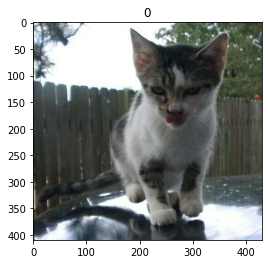

In [8]:
image, label = load('./my_cat_dog/train/cat/cat.11.jpg', 0)

fig, ax = plt.subplots()
ax.imshow(image /255.)
ax.set_title(label)
plt.show()

And it is required to fix the input format. For this purpose, we need to implement `resize` function. Tensorflow has image class(`tf.image`) to handle the image processing in advance. we can use it. Note that `size` argument must have an order of `[height, width]`.

In [9]:
def resize(input_image, size):
    return tf.image.resize(input_image, size)

So this is a sample image of Cat, which has label of '0'(Cats). Then we will implement random crop function. Actually, Tensorflow already contains [random_crop](https://www.tensorflow.org/api_docs/python/tf/image/random_crop) API for convenience.

In [10]:
def random_crop(input_image):
    return tf.image.random_crop(input_image, size=[150, 150, 3])

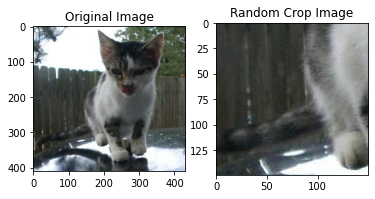

In [12]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_crop(image) / 255.)
ax[1].set_title("Random Crop Image")
plt.show()

And think about that when validation or test data is used. Can Random_crop help the performance of model? You know that validation and test processs don't affect the model training, it just measure the accuracy. So we don't need to data augmentation process in validation and test data. And sometimes random crop may crop the useless section of image that cannot classify correctly. In that case, central_crop function is required, not random crop. So We implement it using tensorflow.

From [documentation](https://www.tensorflow.org/api_docs/python/tf/image/central_crop), it needs to define `central_fraction` as an argument. It means that this API crops from the center point based on the fraction. Our purpose is to made an input data with 150x150x3.
But remember that the size of each image may be different. So we need to resize it in advance.

In [13]:
def central_crop(input_image):
    image = resize(input_image, [176, 176])
    image = tf.image.central_crop(image, central_fraction=0.84)
    image = resize(image, [150, 150])
    return image

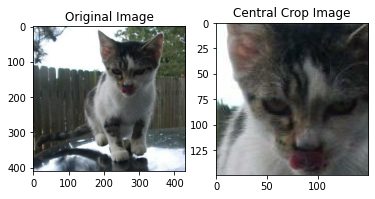

In [14]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_crop(image) / 255.)
ax[1].set_title("Central Crop Image")
plt.show()

Then we can implement random_rotation API.

In [15]:
def random_rotation(input_image):
    angles = np.random.randint(0, 3, 1)
    return tf.image.rot90(input_image, k=angles[0])

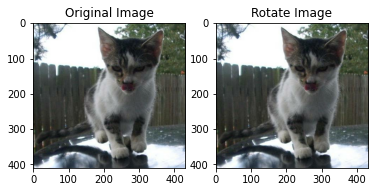

In [16]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_rotation(image) / 255.)
ax[1].set_title("Rotate Image")
plt.show()

Once we define several helper functions for data augmentation, we can merge it in one API, called `random_jitter`. And we can add another image transformation function, like `random_flip_left_right`

In [17]:
def random_jitter(input_image):
    # Resize it to 176 x 176 x 3
    image = resize(input_image, [176, 176])
    # Randomly Crop to 150 x 150 x 3
    image = random_crop(image)
    # Randomly rotation
    image = random_rotation(image)
    # Randomly mirroring
    image = tf.image.random_flip_left_right(image)
    return image

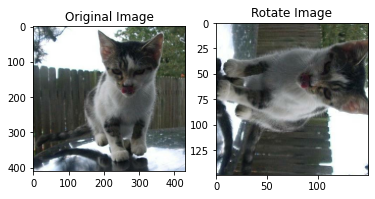

In [19]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_jitter(image) / 255.)
ax[1].set_title("Rotate Image")
plt.show()

One more API we need to implement is `normalize`. Normalization is one of method for rescaling. There are several techniques for normalization. But in this API, our normalize function will be

- convert the value range from [0, 255] to [0, 2]
- move the value range from [0, 2] to [-1, 1]

After that, whole value in image will be in range of [-1, 1]

In [20]:
# normalizing the images to [-1, 1]
def normalize(input_image):
    mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image)) / 2
    input_image = input_image / mid - 1
    return input_image

So we are done. And it will be helpful to make train data and validation data in single API.

In [21]:
def load_image_train(image_file, label):
    image, label = load(image_file, label)
    image = random_jitter(image)
    image = normalize(image)
    return image, label

def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

### Data Pipeline
As you see from previous post, usually dataset pipeline is built for training and test dataset. Actually, it is very efficiency for memory usage, because its type is python generator. For the details check the document in [here](https://www.tensorflow.org/guide/data_performance)

Our data is already separated in each speicies through folder.

- dataset
    - train
        - cat
        - dog
    - test
        - cat
        - dog
    - val
        - cat
        - dog
        
So we need to extract folder name as an label and add it into the data pipeline. So we are doing as follows:

- Build `temp_ds` from cat images (usually have *.jpg)
- Add label (0) in `train_ds` 
- Build `temp_ds` from dog images (usually have *.jpg)
- Add label (1) in `temp_ds`
- Merge two datasets into one 

In [22]:
temp_ds = tf.data.Dataset.list_files(os.path.join('./my_cat_dog', 'train', 'cat', '*.jpg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join('./my_cat_dog', 'train', 'dog', '*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

train_ds = temp_ds.concatenate(temp2_ds)

Then, we can make it suffle or split it with batch size and so on.

In [23]:
buffer_size = tf.data.experimental.cardinality(train_ds).numpy()
train_ds = train_ds.shuffle(buffer_size)\
                   .map(load_image_train, num_parallel_calls=16)\
                   .batch(20)\
                   .repeat()

In [24]:
buffer_size

1000

Same in Validation and Test set, we will make each dataset pipeline through same process. But mentioned before, we don't need to apply data augmentation for these dataset. 

In [25]:
temp_ds = tf.data.Dataset.list_files(os.path.join('./my_cat_dog', 'validation', 'cat', '*.jpg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join('./my_cat_dog', 'validation', 'dog', '*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

val_ds = temp_ds.concatenate(temp2_ds)

val_ds = val_ds.map(load_image_val, num_parallel_calls=16)\
               .batch(20)\
               .repeat()

In [26]:
temp_ds = tf.data.Dataset.list_files(os.path.join('./my_cat_dog', 'test', 'cat', '*.jpg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join('./my_cat_dog', 'test', 'dog', '*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

test_ds = temp_ds.concatenate(temp2_ds)

test_ds = test_ds.map(load_image_val, num_parallel_calls=16)\
                .shuffle(buffer_size)\
               .batch(20)\
               .repeat()

# New Section

### Check functionality of Data Augmentation
We built the datapipe line for the training, validation and test. Now, let's chcek whether it is correct or not.

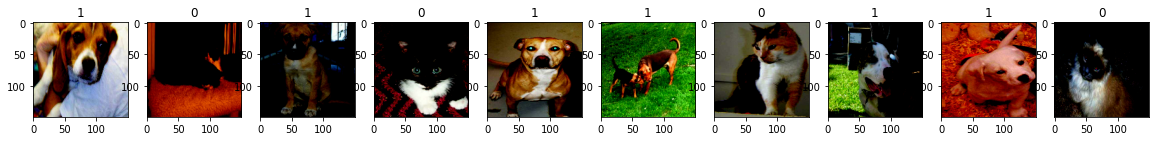

In [27]:
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 6))
    for j in range(10):
        image = images[j].numpy()
        image = image / np.amax(image)
        image = np.clip(image, 0, 1)
        ax[j].imshow(image)
        ax[j].set_title(labels[j].numpy())
plt.show()

### Build the model
Here we will build the CNN classifier. Unlike general Convolution Layer, we will define custom Convolution Layer class with Batch normalization. 

Note that when we use Batch normalization, we need to define whether it is used in training mode or not. Because Batch normalization is one of approaches to help training easily, but in test/validation mode, weight may not be updated. At that case, `training` argument must be `False`. See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) of this usage.

In [28]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.pool(x)
        return x

Using this class, we implement CNN model with Sequential API. And output node will be 2 since our classifier can classify two labels: cat and dog (or 0 and 1).

In [29]:
model = tf.keras.Sequential(name='Cat_Dog_CNN')

model.add(Conv(filters=32, kernel_size=(3, 3)))
model.add(Conv(filters=64, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))

In [30]:
model(images[:1])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5603032, 0.4396968]], dtype=float32)>

### Model Checkpoint
From previous post, we used ModelCheckPoint for saving weight of model. Through this, we can save the weight that trained model can perform best accuracy. Or we can load the best model to enhance the performance.

In [31]:
checkpoint_path = "./train/cat_dog_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

### Compile Model
Actually, All process until here, is the task to define the model. To use the model for training, it is required to define the optimizer and loss function.

**Adaptive Momentum estimation** (Adam for short) is widely used optimizer to find the optimal solution for minimum loss. There needs to be defined learning_rate ($\eta$) for step_size. In this case, we use `1e-4` (or 0.00004) as a learning_rate.

And There are many loss function for classification. Maybe someone confuses about what kind of loss function that can we choose from [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) or [Cross Entropy Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy). Cross Entropy Loss is used for classification when there are two or more label classes. But mentioned in documentation, if the label is provided as an integer (not float or whatever), we need to use `SparseCategoricalCrossentropy`. 

The last argument we need to define is metrics. Metrics is the numerical result to check the performance. Our case is classification, and the performance of classification can be measured from comparing predicted label and ground truth label. So the metrics we need to define is `accuracy` (of course, we can define multiple metrics as a list type)

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "Cat_Dog_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv)                  (1, 74, 74, 32)           1024      
_________________________________________________________________
conv_1 (Conv)                (1, 36, 36, 64)           18752     
_________________________________________________________________
conv_2 (Conv)                (1, 17, 17, 128)          74368     
_________________________________________________________________
conv_3 (Conv)                (1, 7, 7, 128)            148096    
_________________________________________________________________
flatten (Flatten)            (1, 6272)                 0         
_________________________________________________________________
dense (Dense)                (1, 512)                  3211776   
_________________________________________________________________
dense_1 (Dense)              (1, 2)                    

Finally, we can extract the summary of our CNN model that have almost 3.5 million parameters.

### Train the model
We can train our model with `.fit()` method. And also we need to use checkpoint callback that we defined earlier.

In [34]:
train_len = int(len(glob(os.path.join('./my_cat_dog', 'train', 'cat', '*.jpg'))) * 2)
val_len = int(len(glob(os.path.join('./my_cat_dog', 'validation', 'cat', '*.jpg'))) * 2)
test_len = int(len(glob(os.path.join('./my_cat_dog', 'test', 'cat', '*.jpg'))) * 2)

In [35]:
print(train_len)
print(val_len)
print(test_len)
print(type(train_len))
print(type(val_len))
print(type(test_len))


1000
500
1000
<class 'int'>
<class 'int'>
<class 'int'>


In [36]:
model.fit(train_ds, steps_per_epoch= int(train_len / 20),
          validation_data=val_ds,
          validation_steps=int(val_len/20),
          epochs=5,
          callbacks=[cp_callback])

Epoch 1/5
50/50 [==============================] - 69s 1s/step - loss: 0.9851 - accuracy: 0.5860 - val_loss: 0.7544 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.75443, saving model to ./train/cat_dog_cnn/cp-0001.ckpt
Epoch 2/5
50/50 [==============================] - 66s 1s/step - loss: 0.6667 - accuracy: 0.6580 - val_loss: 0.7634 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.75443
Epoch 3/5
50/50 [==============================] - 67s 1s/step - loss: 0.5761 - accuracy: 0.6980 - val_loss: 0.8232 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.75443
Epoch 4/5
50/50 [==============================] - 66s 1s/step - loss: 0.5652 - accuracy: 0.7240 - val_loss: 0.9253 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.75443
Epoch 5/5
50/50 [==============================] - 68s 1s/step - loss: 0.5103 - accuracy: 0.7530 - val_loss: 0.8831 - val_accuracy: 0.5000

Epoch 00005: val_loss did not improve from 0.7

### Model Evaluation
After training, we can get 85% of training accuracy, and 78% of validation accuracy. But the important thing is that can we use this model for inference. And that's why we split raw data with training and test data. Test set must be unknown or unseen data for the training model. First, let's evaluate our trained model. 

In [37]:
model.evaluate(test_ds, steps=test_len / 20)

50/50 [==============================] - 17s 285ms/step - loss: 0.8690 - accuracy: 0.5030


[0.8690063953399658, 0.503000020980835]

The accuracy of test dataset is quite lower than training/validation accuracy. Because our model is not perfect model for classification, and test dataset may be the unknown data for trained model. Maybe the class distribution is different from training set and test set (or imbalance of class) 

Anyway, remember that we used callback function for saving best performance model's weight. If we can redefine our structure of model, we can load the weight in that model. So we don't need retrain the model while using many hours.


In [38]:
model_inf = tf.keras.Sequential(name='Cat_Dog_CNN_load')

model_inf.add(Conv(filters=32, kernel_size=(3, 3)))
model_inf.add(Conv(filters=64, kernel_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3)))

model_inf.add(tf.keras.layers.Flatten())  
model_inf.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu)) 
model_inf.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))  

model_inf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])

for images, labels in train_ds.take(1):
    outputs = model_inf(images, training=False)
    
# Load model
model_inf.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [39]:
model_inf.evaluate(test_ds, steps=test_len / 20)

50/50 [==============================] - 17s 285ms/step - loss: 0.7533 - accuracy: 0.5000


[0.7533383369445801, 0.5]

Almost same result as you saw before. And we can also visualize our performance with images. Here, we can display the correct result with blue color, incorrect result with red color in title.

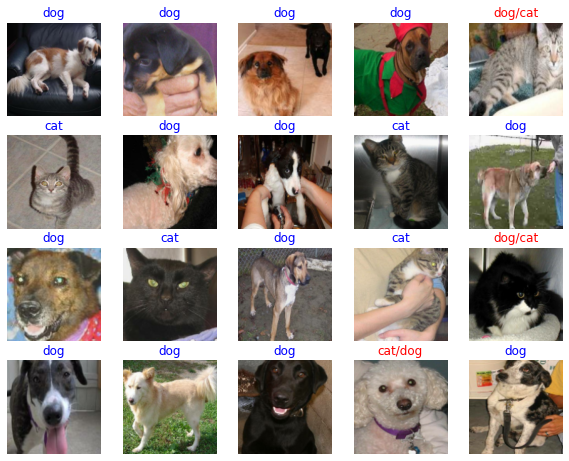

In [40]:
test_batch_size = 25

for images, labels in test_ds.take(1):
    predictions = model_inf(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

### Transfer Learning
We built our CNN model for cat-dog classification. But can we make our model with state-of-the-art approach? For those who want to use state-of-the-art model, there are some pretrained model, like `efficientNet`, `inception`, `vgg` etc. (check the detail usage in [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)).

In this section, we will build our model with VGG16.

![vgg16](https://github.com/goodboychan/goodboychan.github.io/blob/main/_notebooks/image/vgg16-neural-network.jpg?raw=1)

VGG16 was introduced in the ILSVRC 2014. You can check the detail architecture and implementation from the [paper](https://arxiv.org/abs/1409.1556) (Simonyan et al, 2014). You can borrow the structure of model as an convolutional layer like our `Conv` layer.

In [ ]:
conv_vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150, 150, 3))

Actually, this model is trained with 1000 classes included in ImageNet dataset. But in our task, our task is to classify only 2 classes, not 1000. So it is not required whole layers. And in Deep Neural Network, the layer close to input usually does extract the general features. and the layer close to output usually extract the specific feature of class. 

For transfer learning, we can borrow the general extraction layer, and add it as a convolution layer. Then you can add dense layer for the output to can get 2 labels, same as before. So you can see the argument `include_top` in `VGG16`. That means that we notice that only use specific layer, not whole layers.

So our implementation will be like this,

In [ ]:
model_vgg = tf.keras.Sequential(name='Cat_Dog_CNN_VGG16')
model_vgg.add(conv_vgg16)
model_vgg.add(tf.keras.layers.Flatten())
model_vgg.add(tf.keras.layers.Dense(units=256, activation=tf.keras.activations.relu))
model_vgg.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))

We can check our model structure,

In [ ]:
for variable in model_vgg.trainable_variables:
    print(variable.name)

block1_conv1/kernel:0
block1_conv1/bias:0
block1_conv2/kernel:0
block1_conv2/bias:0
block2_conv1/kernel:0
block2_conv1/bias:0
block2_conv2/kernel:0
block2_conv2/bias:0
block3_conv1/kernel:0
block3_conv1/bias:0
block3_conv2/kernel:0
block3_conv2/bias:0
block3_conv3/kernel:0
block3_conv3/bias:0
block4_conv1/kernel:0
block4_conv1/bias:0
block4_conv2/kernel:0
block4_conv2/bias:0
block4_conv3/kernel:0
block4_conv3/bias:0
block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense_14/kernel:0
dense_14/bias:0
dense_15/kernel:0
dense_15/bias:0


But we don't want to retrain whole VGG16 Conv layers, since it is already trained with ImageNet dataset. But we need to **train** the Dense layer for classifying cats and dogs. This kind of process is called **fine-tuning**. To do this, we need to change the `trainable` property of each layers.

In [ ]:
conv_vgg16.trainable = True

set_trainable = False

for layer in conv_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

After that, we found out that trainable variable of our model is smaller than before.

In [ ]:
for variable in model_vgg.trainable_variables:
    print(variable.name)

block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense_14/kernel:0
dense_14/bias:0
dense_15/kernel:0
dense_15/bias:0


### Train and Evaluation
Same processes are processed here, training and evaluation. We expect our accuracy is much higher than our built model.

In [ ]:
model_vgg.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])

In [ ]:
checkpoint_path = "./train/exp_pre_trained/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                verbose=1)

In [ ]:
model_vgg.fit(train_ds, steps_per_epoch = int(train_len / 20),
          validation_data=val_ds, 
          validation_steps= int(val_len / 20),
          epochs= 5,
          callbacks= [cp_callback])

Epoch 1/5
50/50 [==============================] - 244s 5s/step - loss: 0.3329 - accuracy: 0.8390 - val_loss: 0.2517 - val_accuracy: 0.8920

Epoch 00001: saving model to ./train/exp_pre_trained/cp.ckpt
Epoch 2/5
50/50 [==============================] - 242s 5s/step - loss: 0.1015 - accuracy: 0.9590 - val_loss: 0.1647 - val_accuracy: 0.9360

Epoch 00002: saving model to ./train/exp_pre_trained/cp.ckpt
Epoch 3/5
50/50 [==============================] - 242s 5s/step - loss: 0.0682 - accuracy: 0.9770 - val_loss: 0.1761 - val_accuracy: 0.9300

Epoch 00003: saving model to ./train/exp_pre_trained/cp.ckpt
Epoch 4/5
50/50 [==============================] - 242s 5s/step - loss: 0.0467 - accuracy: 0.9890 - val_loss: 0.1630 - val_accuracy: 0.9340

Epoch 00004: saving model to ./train/exp_pre_trained/cp.ckpt
Epoch 5/5
50/50 [==============================] - 240s 5s/step - loss: 0.0175 - accuracy: 0.9940 - val_loss: 0.2468 - val_accuracy: 0.9320

Epoch 00005: saving model to ./train/exp_pre_traine

In [ ]:
model_vgg.evaluate(test_ds, steps=test_len / 20)

50/50 [==============================] - 138s 3s/step - loss: 0.1621 - accuracy: 0.9500


[0.1620929092168808, 0.949999988079071]

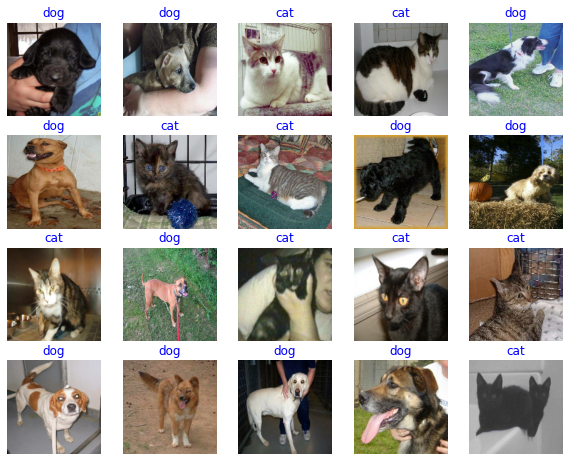

In [ ]:
test_batch_size = 25

for images, labels in test_ds.take(1):
    predictions = model_vgg(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

As you can see, the validation accuracy and test accuracy is much higher than our model. And we can also reduce our model training epoch, and get that result. Actually, it is reasonable result that ImageNet dataset includes lots of image data containing cats and dogs. And VGG16 is efficient model for classification that it was the winner in ILSVRC 2014. Maybe you can use another model and fine-tuning for your task. It's up to you.

### Summary
In this post, we build cat-dot classifier with CNN model. To overcome the limitation of dataset amount, we can apply **data augmentation** (Of course, you can apply various transformation function in your dataset), and re-generate the dataset. After that, we made dataset pipeline for memory efficiency.

Through previous posts, we learn basic implementation of CNN. So we applied some techniques like **batch normalization**, and train it. Training is successful, but we can improve our model with **transfer learning**. So we borrow the convolution layer of **VGG16** (the winner of ILSVRC 2014) and **fune-tuned** some layers. After training, we can get almost 94% classification accuracy from our model. 